In [3]:
!git clone https://github.com/sheelfshah/banditpylib.git
%cd banditpylib
!make install
!pip3 uninstall -y matplotlib
!pip3 install matplotlib==3.1.3

Cloning into 'banditpylib'...
remote: Enumerating objects: 7359, done.
remote: Counting objects: 100% (755/755), done.
remote: Compressing objects: 100% (391/391), done.
remote: Total 7359 (delta 562), reused 502 (delta 363), pack-reused 6604
Receiving objects: 100% (7359/7359), 10.64 MiB | 11.22 MiB/s, done.
Resolving deltas: 100% (5482/5482), done.
/content/banditpylib/banditpylib/banditpylib
pip install --upgrade pip
make: pip: Command not found
makefile:26: recipe for target 'install_requirements' failed
make: *** [install_requirements] Error 127
/bin/bash: pip3: command not found
/bin/bash: pip3: command not found


In [2]:
# run only if updating
%cd banditpylib
!git pull
!pip install -e .
# restart runtime

/content/banditpylib/banditpylib
Already up to date.
/bin/bash: pip: command not found


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tempfile
import seaborn as sns
import random
sns.set(style="darkgrid")

from banditpylib import trials_to_dataframe
from banditpylib.arms import GaussianArm
from banditpylib.bandits import MultiArmedBandit
from banditpylib.protocols import CollaborativeLearningProtocol, SinglePlayerProtocol
from banditpylib.learners.collaborative_learner import (
    LilUCBHeuristicCollaborativeBAIAgent as Agent,
    LilUCBHeuristicCollaborativeBAIMaster as Master,
    CollaborativeBAILearner as Learner
)
from banditpylib.learners.mab_fcbai_learner import LilUCBHeuristic

In [5]:
means = [(i/10)**0.5 for i in range(1,10)]
random.shuffle(means)
print(means)

[0.8944271909999159, 0.4472135954999579, 0.5477225575051661, 0.7745966692414834, 0.6324555320336759, 0.8366600265340756, 0.9486832980505138, 0.7071067811865476, 0.31622776601683794]


In [6]:
confidence = 0.99
num_learners, rounds, horizon = 10, 5, 20000
param_dict = {
    "rounds": [rounds] * num_learners,
    "horizon": [horizon] * num_learners,
    "num_agents": [2*i + 1 for i in range(num_learners)]
}

arms = [GaussianArm(mu=mean, std=1) for mean in means]
bandit = MultiArmedBandit(arms=arms)
masters = [Master(arm_num=len(arms), rounds=param_dict["rounds"][i], horizon=param_dict["horizon"][i],
                  num_agents=param_dict["num_agents"][i], name="master %d" % (i+1)) for i in range(num_learners)]
agents = [Agent(arm_num=len(arms), rounds=param_dict["rounds"][i], horizon=param_dict["horizon"][i],
                name="agent %d" % (i+1)) for i in range(num_learners)]

learners = [Learner(agent=agents[i], master=masters[i], num_agents=param_dict["num_agents"][i],
                    name="learner %d" % (i+1)) for i in range(num_learners)]
trials = 10

In [7]:
game1 = CollaborativeLearningProtocol(bandit=bandit, learners=learners)
game1.play(trials=trials, output_filename="trial_outputs1.txt")
data_df1 = trials_to_dataframe("trial_outputs1.txt")
!rm trial_outputs1.txt

In [8]:
learners = [LilUCBHeuristic(len(arms), confidence)]
game2 = SinglePlayerProtocol(bandit=bandit, learners=learners, horizon=horizon)
game2.play(trials=trials, output_filename="trial_outputs2.txt")
data_df2 = trials_to_dataframe("trial_outputs2.txt")
!rm trial_outputs2.txt

In [9]:
data_df = pd.concat([data_df1, data_df2])
data_df["confidence"] = confidence

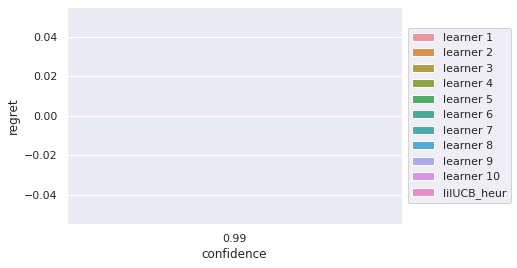

In [10]:
fig = plt.figure()
ax = plt.subplot(111)
sns.barplot(x='confidence', y='regret', hue='learner', data=data_df)
plt.ylabel('regret')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

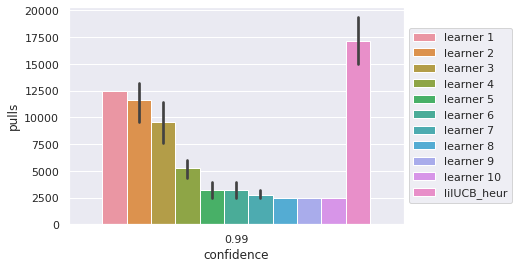

In [11]:
fig = plt.figure()
ax = plt.subplot(111)
sns.barplot(x='confidence', y='total_actions', hue='learner', data=data_df)
plt.ylabel('pulls')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [12]:
confidence = 0.99
num_learners = 10
rounds1, horizon1 = 3, 20000
rounds2, horizon2 = 10, 20000
param_dict1, param_dict2 = {}, {}
num_agents = [2*i + 1 for i in range(num_learners)]
for i in range(num_learners):
  param_dict1[i] = {"rounds": rounds1, "horizon": horizon1, "num_agents": num_agents[i]}
  param_dict2[i] = {"rounds": rounds2, "horizon": horizon2, "num_agents": num_agents[i]}

arms = [GaussianArm(mu=mean, std=1) for mean in means]
bandit = MultiArmedBandit(arms=arms)

masters1 = [Master(arm_num=len(arms), rounds=param_dict1[i]["rounds"], horizon=param_dict1[i]["horizon"],
                  num_agents=param_dict1[i]["num_agents"], name="master1 %d" % (i+1)) for i in range(num_learners)]
agents1 = [Agent(arm_num=len(arms), rounds=param_dict1[i]["rounds"], horizon=param_dict1[i]["horizon"],
                name="agent1 %d" % (i+1)) for i in range(num_learners)]
learners1 = [Learner(agent=agents1[i], master=masters1[i], num_agents=param_dict1[i]["num_agents"],
                    name="learner1 %d" % (i+1)) for i in range(num_learners)]

masters2 = [Master(arm_num=len(arms), rounds=param_dict2[i]["rounds"], horizon=param_dict2[i]["horizon"],
                  num_agents=param_dict2[i]["num_agents"], name="master2 %d" % (i+1)) for i in range(num_learners)]
agents2 = [Agent(arm_num=len(arms), rounds=param_dict2[i]["rounds"], horizon=param_dict2[i]["horizon"],
                name="agent2 %d" % (i+1)) for i in range(num_learners)]
learners2 = [Learner(agent=agents2[i], master=masters2[i], num_agents=param_dict2[i]["num_agents"],
                    name="learner2 %d" % (i+1)) for i in range(num_learners)]

trials = 20

In [13]:
game1 = CollaborativeLearningProtocol(bandit=bandit, learners=learners1)
game1.play(trials=trials, output_filename="trial_outputs1.txt")
data_df1 = trials_to_dataframe("trial_outputs1.txt")
game2 = CollaborativeLearningProtocol(bandit=bandit, learners=learners2)
game2.play(trials=trials, output_filename="trial_outputs2.txt")
data_df2 = trials_to_dataframe("trial_outputs2.txt")
!rm trial_outputs1.txt !rm trial_outputs2.txt

rm: cannot remove '!rm': No such file or directory


In [14]:
def get_rounds_from_learner_name(learner):
  i = int(learner.split()[0][-1])
  if i==1:
    return rounds1
  return rounds2

def get_num_agents_from_learner_name(learner):
  i = int(learner.split()[-1])
  return num_agents[i-1]

In [15]:
num_agents

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19]

In [16]:
data_df = pd.concat([data_df1, data_df2])
data_df["rounds"] = data_df["learner"].apply(get_rounds_from_learner_name)
data_df["num_agents"] = data_df["learner"].apply(get_num_agents_from_learner_name)

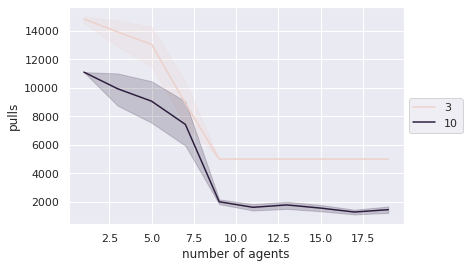

In [17]:
fig = plt.figure()
ax = plt.subplot(111)
sns.lineplot(x='num_agents', y='total_actions', hue='rounds', data=data_df)
plt.ylabel('pulls')
plt.xlabel('number of agents')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

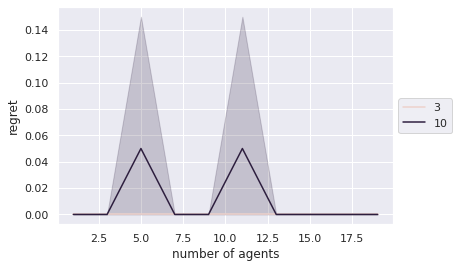

In [18]:
fig = plt.figure()
ax = plt.subplot(111)
sns.lineplot(x='num_agents', y='regret', hue='rounds', data=data_df)
plt.ylabel('regret')
plt.xlabel('number of agents')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()